In [19]:
import sys
import os
sys.path.insert(0, os.getcwd()+'/src/')
sys.path.insert(0, '/home/mcarenso/code/stage-2023-multiscale-extremes/scripts/src/')
from myImports import *
%matplotlib inline
%load_ext autoreload

path = "/homedata/mcarenso/distrib/dist_SAM_Native_Prec_sizemax_1e7.pkl"
distrib = pickle.load(open(path, "rb"))
n_days = 8

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## where fall rains a part from MCS


In [20]:
## import SAM pr data
sim_path = "/bdd/MT_WORKSPACE/MCS/RCE/SAM/INPUTS/v2023_05/SAM_RCE_large300_2D_pr.nc"
Precip = xr.open_dataarray(sim_path).sel(time=slice(0,n_days*24*2))

# compute dist_SAM_prec
dist_SAM_Prec = cs.Distribution('Precip SAM', bintype = 'invlogQ', nd =5)
dist_SAM_Prec.computeDistribution(sample = Precip.values)
dist_SAM_Prec.storeSamplePoints(sample = Precip.values)

#import corresponding MCS label map 
file_seg='/bdd/MT_WORKSPACE/MCS/RCE/SAM/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/TOOCAN_2.07_SAM_large300_2D_irtb.nc'
seg = xr.open_dataarray(file_seg).sel(time=slice(0,n_days*24*2))

MCS_label = seg.values
MCS_label = MCS_label

In [21]:
label_mask = MCS_label.copy()
label_mask = np.where(MCS_label > 0, 1, 0)

Pr = Precip.copy()
Pr = np.where(Pr <= 0, -1, Pr)
Pr = np.where(Pr > 0, 0, Pr)
Pr = np.where(label_mask==1, 1, Pr)

np.unique(label_mask)

array([0, 1])

In [ ]:
# ## imshow MCS label map with one color per MCS label, and Precip in blue on top
# fig, axs = plt.subplots(96, 1, figsize=(48,3*96))
# colors = [(0, 'lightgoldenrodyellow'), (0.5, 'blue'), (1, 'white')]
# cmap = LinearSegmentedColormap.from_list('sunny_rain', colors)

# for i, ax in enumerate(axs):
#     heatmap = ax.imshow(Pr[i,:,:], cmap=cmap, aspect='auto')

# # Add a colorbar
# cbar = plt.colorbar(heatmap, ax=ax)
# cbar.set_label('Precipitation')
# plt.tight_layout()
# plt.show()

## let's make a video out of it 

In [22]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import os

# Set up the folder to save the images
image_folder = "/homedata/mcarenso/figures/rain_out_of_MCS/frames/focus_on_750_1500/"
os.makedirs(image_folder, exist_ok=True)

# Define the colormap for MCS labels
colors = [(0, 'darkkhaki'), (0.5, 'blue'), (1, 'white')]
cmap = LinearSegmentedColormap.from_list('sunny_rain', colors)

# Generate and save the images for each frame
for i in range(96):
    fig, ax = plt.subplots(figsize=(96, 9))
    heatmap = ax.imshow(Pr[i, :, 750:1500], cmap=cmap, aspect='auto')
    cbar = plt.colorbar(heatmap, ax=ax)
    cbar.set_label('Precipitation')

    # Save the map as an image
    plt.savefig(os.path.join(image_folder, f"frame_{i:03d}.png"), bbox_inches="tight")
    plt.close()

In [13]:
import cv2
import os
import re

def sorted_alphanumeric(data):
    """
    Sorts the given list in alphanumeric order.
    """
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

def create_video(image_folder, output_path, fps=60):
    """
    Creates a video from a sequence of images.
    """
    images = sorted_alphanumeric(os.listdir(image_folder))

    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, _ = frame.shape

    video = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

    for image in images:
        frame = cv2.imread(os.path.join(image_folder, image))
        video.write(frame)

    cv2.destroyAllWindows()
    video.release()
    
output_path = "/homedata/mcarenso/figures/rain_out_of_MCS/video/focus_on_750_1500/2days_test.mp4"


In [15]:
create_video(image_folder, output_path, fps=24)

## Some stuff


In [ ]:
n_days = 20 # number of days to extract 

ds_SAM_Prec_mean = xr.open_dataset(f"/homedata/mcarenso/outputs/rcemip_prec_1°x1day_remeshed_by_mean_with_300K_for_{n_days}days.nc")["Prec"].to_numpy()
#Compute Distribution for ds_SAM_Prec_mean.
original_shape = (64, 4, n_days)
#ds_SAM_Prec_mean = ds_SAM_Prec_mean.reshape(-1)
dist_SAM_Prec_mean = cs.Distribution(name="SAM Precipitation", bintype = "invlogQ", nd = 4, fill_last_decade=True)
dist_SAM_Prec_mean.computeDistribution(sample = ds_SAM_Prec_mean)
dist_SAM_Prec_mean.storeSamplePoints(sample = ds_SAM_Prec_mean)

ds_SAM_Prec_max = xr.open_dataset(f"/homedata/mcarenso/outputs/rcemip_prec_1°x1day_remeshed_by_max_with_300K_for_{n_days}days.nc")["Prec"].to_numpy()
#Compute Distribution for dsSAM_Prec_max
#ds_SAM_Prec_max = ds_SAM_Prec_max.flatten()
dist_SAM_Prec_max = cs.Distribution(name="SAM Precipitation", bintype = "invlogQ", nd = 4, fill_last_decade=True)
dist_SAM_Prec_max.computeDistribution(sample = ds_SAM_Prec_max)
dist_SAM_Prec_max.storeSamplePoints(sample = ds_SAM_Prec_max)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


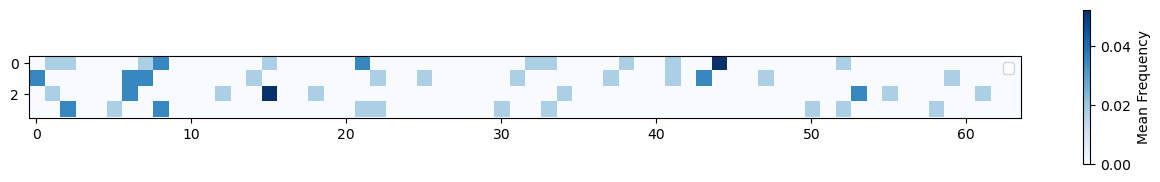

In [91]:
plt.figure(figsize=(16,2))

map_mean = np.zeros(shape = original_shape[0:2])
Xmean = 0
for i_bin, bin in zip(range(20, len(dist_SAM_Prec_mean.bins)), dist_SAM_Prec_mean.bins[20:-1]):
    xy_coords = np.transpose((np.unravel_index(dist_SAM_Prec_mean.bin_locations[i_bin], original_shape))[0:2])
    for xy in xy_coords:
        x, y = xy
        map_mean[x,y]+=1
        Xmean +=1
map_mean = map_mean/Xmean
plt.imshow(map_mean.T, cmap='Blues')
cbar = plt.colorbar()
cbar.set_label('Mean Frequency')
plt.legend()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


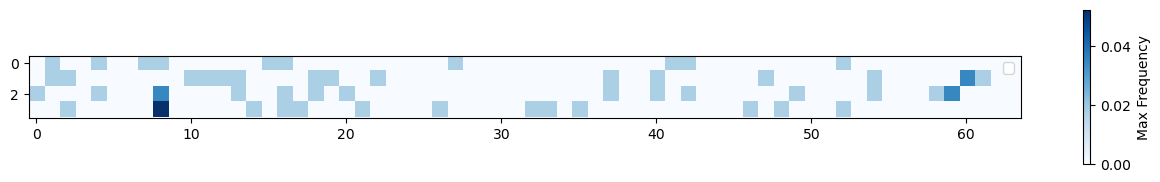

In [92]:
plt.figure(figsize=(16,2))

map_max = np.zeros(shape = original_shape[0:2])
Xmax = 0
for i_bin, bin in zip(range(20, len(dist_SAM_Prec_max.bins)), dist_SAM_Prec_max.bins[20:-1]):
    xy_coords = np.transpose((np.unravel_index(dist_SAM_Prec_max.bin_locations[i_bin], original_shape))[0:2])
    for xy in xy_coords:
        x, y = xy
        map_max[x,y]+=1
        Xmax +=1
map_max = map_max/Xmax
plt.imshow(map_max.T, cmap='Blues')
cbar = plt.colorbar()
cbar.set_label('Max Frequency')
plt.legend()


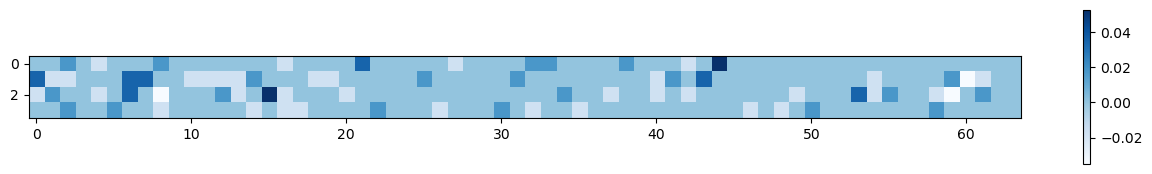

In [95]:
plt.figure(figsize=(16,2)) 

map = map_mean - map_max

plt.imshow(map.T, cmap='Blues') 
cbar = plt.colorbar()


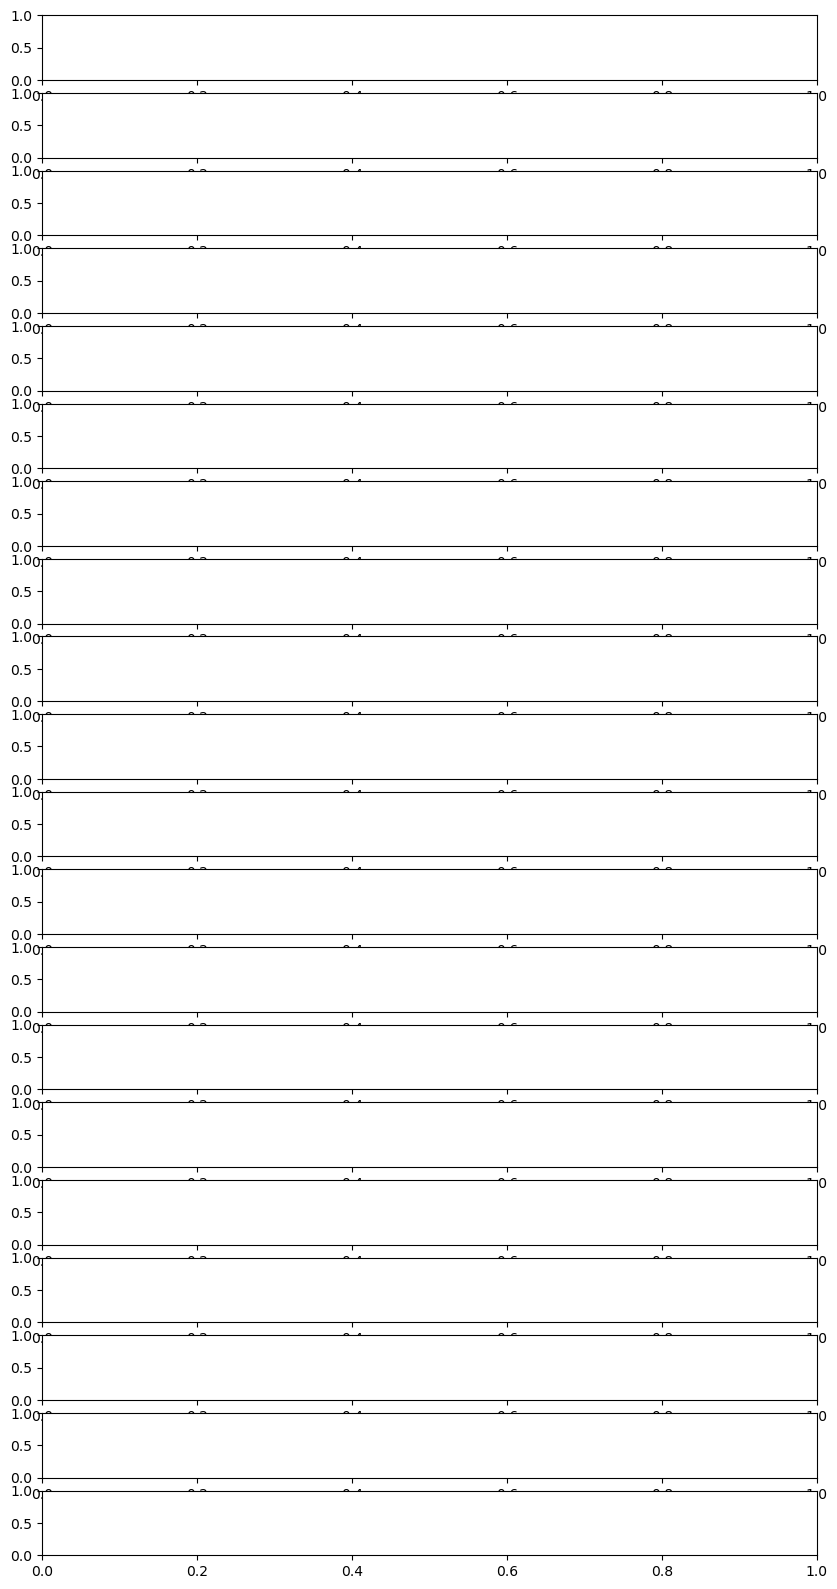

In [99]:
fig, axs = plt.subplots(20, 1, figsize=(10, 20))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(ds_SAM_Prec_mean[i,:,:], cmap='Blues')